In [1]:
# Ollama
from openai import OpenAI

openai_api_key = "YOUR_API_KEY"
openai_api_base = "http://localhost:11434/v1"

llm = OpenAI(api_key=openai_api_key, base_url=openai_api_base)

In [2]:
import json
import chromadb
from chromadb.utils import embedding_functions

# ChromaDB setup
chromadb_client = chromadb.PersistentClient(path="./db")
db = chromadb_client.get_or_create_collection(name="financial_docs")

In [3]:
def parse_convfinqa_dataset(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    parsed_data = []
    
    for entry in data:
        # Combine pre_text, post_text, and table content into a single text block
        combined_text = "\n".join(entry['pre_text']) + "\n" + "\n".join(entry['post_text'])
        
        # Process the table to include in the text block
        table_text = []
        for row in entry['table']:
            # Join each cell in the row with a tab for clarity
            table_text.append("\t".join(row))
        table_text = "\n".join(table_text)
        
        # Combine all text and table data
        full_text = combined_text + "\n\n" + "Table Data:\n" + table_text
        
        # Create an entry for ChromaDB ingestion
        parsed_entry = {
            'id': entry['id'],
            'text': full_text,
            # 'question': entry['qa']['question'],
            # 'answer'|: entry['qa']['answer']
        }
        parsed_data.append(parsed_entry)
    
    return parsed_data


In [4]:
def query_chromadb(question, collection):
    results = collection.query(query_texts=[question], n_results=5)
    return results

# Example usage
question = "what was the percentage change in the net cash from operating activities from 2008 to 2009"
response = query_chromadb(question, db)

print(response)


{'ids': [['Single_JKHY/2009/page_28.pdf-3', 'Single_JPM/2013/page_104.pdf-2', 'Single_CE/2010/page_134.pdf-2', 'Single_SLG/2013/page_133.pdf-4', 'Double_UPS/2009/page_33.pdf']], 'distances': [[0.7791805517656116, 1.2058874709901484, 1.356978658360858, 1.3653644636994102, 1.3902175425641872]], 'metadatas': [[None, None, None, None, None]], 'embeddings': None, 'documents': [['26 | 2009 annual report in fiscal 2008 , revenues in the credit union systems and services business segment increased 14% ( 14 % ) from fiscal 2007 .\nall revenue components within the segment experienced growth during fiscal 2008 .\nlicense revenue generated the largest dollar growth in revenue as episys ae , our flagship core processing system aimed at larger credit unions , experienced strong sales throughout the year .\nsupport and service revenue , which is the largest component of total revenues for the credit union segment , experienced 34 percent growth in eft support and 10 percent growth in in-house suppor

In [5]:
from langchain_chroma import Chroma
from sentence_transformers import SentenceTransformer

class CustomEmbeddings:
    def __init__(self, model="all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model, trust_remote_code=True)

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        return [self.model.encode(t).tolist() for t in texts]
    
    def embed_query(self, query: str) -> list[float]:
        return self.model.encode([query])[0].tolist()
        
# Initialize Chroma
vector_store = Chroma(
    client=chromadb_client,
    collection_name="financial_docs",
    persist_directory="./db",  # Where to save data locally, remove if not neccesary
    embedding_function=CustomEmbeddings("all-MiniLM-L6-v2")
)

print(CustomEmbeddings().embed_query("asd"))

/Users/juskazan/Projects/TomoroAI/.venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/Users/juskazan/Projects/TomoroAI/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the 

[-0.12403251975774765, -0.006126576103270054, -0.007643955294042826, 0.05117763578891754, -0.008589210920035839, -0.021051358431577682, 0.06903959065675735, -0.01971042901277542, -0.021294105798006058, -0.029979726299643517, 0.03589785471558571, -0.015056969597935677, -0.03433169797062874, -0.006830163765698671, -0.028852852061390877, -0.02722444012761116, 0.02340937778353691, -0.048426222056150436, -0.11704225093126297, -0.01990649662911892, -0.041199203580617905, 0.09209650009870529, 0.026396270841360092, 0.010833492502570152, 0.057644251734018326, -0.05959760770201683, 0.04232749715447426, -0.03867774456739426, 0.004769627004861832, -0.10280600935220718, 0.06895194947719574, -0.005827539134770632, 0.047956064343452454, 0.015917977318167686, -0.008895812556147575, -0.02368972636759281, 0.04214287921786308, -0.06624723225831985, -0.017846476286649704, 0.04278495907783508, -0.01611267402768135, 0.034301791340112686, -0.024904398247599602, 0.04754626005887985, 0.009209901094436646, -0.0

In [13]:
from typing import Literal, TypedDict
from langchain_chroma import Chroma
from langgraph.graph import StateGraph, END, START
from langgraph.graph import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from typing import TypedDict, Annotated, Sequence
from langchain.prompts import PromptTemplate
from operator import add
from langfuse import Langfuse
from langfuse.callback import CallbackHandler
from langchain_openai import ChatOpenAI
import pprint

langfuse_handler = CallbackHandler(
    secret_key="sk-lf-a65b23f9-0ffb-4063-8c09-5e1c265e9c4a",
    public_key="pk-lf-c5d11bfe-392e-4ae1-ad90-aa4a8639965c",
    host="https://cloud.langfuse.com"
  # host="https://us.cloud.langfuse.com", # 🇺🇸 US region
)

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages] # Chat messages
    steps: Annotated[list[str], add] # Agent steps
    question: str # Query executed against the database to retrieve documents
    documents: list[str] # Retrieved documents (context)
    answer: str # Generated final answer

# Prompt
prompt_template = PromptTemplate(
    template="""You are a investment analyst. You will be given: 
    <INSTRUCTIONS>
    You will be provided:
    1. a QUESTION asked by the user
    2. DOCUMENTS provided by an automated context retrieval system
    
    Your task is to use the context to provide a relevant ANSWER to the QUESTION

    Only answer what the user is asking and nothign else
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 

    Avoid simply stating the correct answer at the outset.

    If there is no relevant context provided, state that at the outset.
    </INSTRUCTIONS>
    <QUESTION>{question}</QUESTION>\n
    <DOCUMENTS>
    \n\n {documents}
    </DOCUMENTS>\n\n
    <QUESTION>{question}</QUESTION>\n
    """,
    input_variables=["question", "documents"],
)

system_prompt = """Be a helpful assistant"""

def extract_question(state: AgentState) -> AgentState:
    messages = state["messages"]
    question = messages[-1].content
    return {"question": question, "steps": ["extract_question"]}

def retrieve_from_vector_db(state: AgentState) -> AgentState:
    question = state["question"]
    result = vector_store.similarity_search(question, k=5)

    return {
        "steps": [f"retrieve('{question}')"], 
        "documents": result, 
    }

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
    
def rerank(state: AgentState) -> AgentState:
    question = state["question"]
    documents = state["documents"]

    # TODO: rerank

    return {"steps": ["rerank"]}
    
    
# Define the function that calls the model
def generate(state: AgentState) -> AgentState:
    messages = state["messages"]
    question = state["question"]
    documents = state["documents"]

    prompt = prompt_template.format(**{"question": question, "documents": format_docs(documents)})
    messages[-1] = HumanMessage(prompt)
    
    messages_openai = []
    for message in messages:
        if type(message) == HumanMessage:
            role = "user"
        elif type(message) == AIMessage:
            role = "assistant",
        elif type(message) == SystemMessage:
            role = "system"
        else:
            raise ValueError("No such message type allowed")
        messages_openai.append(({"role": role, "content": message.content}))


    response = llm.chat.completions.create(model="llama3.1", messages=messages_openai)
    response_message = AIMessage(response.choices[0].message.content)
    # We return a list, because this will get added to the existing list
    return {"messages": [response_message]}

# Define the config
class GraphConfig(TypedDict):
    retrieval_k: int = 5


# Define a new graph
workflow = StateGraph(AgentState, config_schema=GraphConfig)

# Define the two nodes we will cycle between
workflow.add_node("extract_question", extract_question)
workflow.add_node("retriever", retrieve_from_vector_db)
workflow.add_node("reranker", rerank)
workflow.add_node("generator", generate)



# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge(START, "extract_question")
workflow.add_edge("extract_question", "retriever")
workflow.add_edge("retriever", "reranker")
workflow.add_edge("reranker", "generator")
workflow.add_edge("generator", END)


# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
graph = workflow.compile()

inputs = {
    "messages": [
        HumanMessage("what was the percentage change in the net cash from operating activities from 2008 to 2009?"),
    ]
}


for output in graph.stream(inputs, config={"callbacks": [langfuse_handler]}):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

"Output from node 'extract_question':"
'---'
{ 'question': 'what was the percentage change in the net cash from operating '
              'activities from 2008 to 2009',
  'steps': ['extract_question']}
'\n---\n'
"Output from node 'retriever':"
'---'
{ 'documents': [ Document(page_content='26 | 2009 annual report in fiscal 2008 , revenues in the credit union systems and services business segment increased 14% ( 14 % ) from fiscal 2007 .\nall revenue components within the segment experienced growth during fiscal 2008 .\nlicense revenue generated the largest dollar growth in revenue as episys ae , our flagship core processing system aimed at larger credit unions , experienced strong sales throughout the year .\nsupport and service revenue , which is the largest component of total revenues for the credit union segment , experienced 34 percent growth in eft support and 10 percent growth in in-house support .\ngross profit in this business segment increased $ 9344 in fiscal 2008 compared to

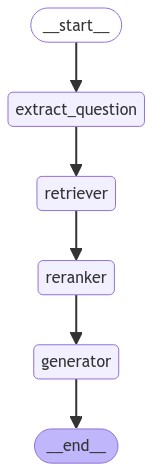

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass